In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics  import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import warnings
import statsmodels.api as sm
import scipy.stats as stats
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import scipy.stats as stats
import pmdarima as pm
import yfinance as yf

In [180]:
# Helpers

# Stationarity Test
def perform_adf_testing(adobe_stocks):
    # H0: Non-stationary
    # H1: Stationary
    print('Aadobe_stocks Test Result')
    print('---------------')
    for col in adobe_stocks.columns:
        result = adfuller(adobe_stocks[col])
        print(f'{col}:')
        print(f'Aadobe_stocks Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print(f'Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
        if result[1] < 0.05:
            print(f'{col} is stationary')
        else:
            print(f'{col} is non-stationary')
        print('---------------')


from statsmodels.tsa.stattools import kpss

def perform_kpss_testing(series, significance_level=0.05):
    # H0: Trend stationary
    # H1: Non-trend stationary
    print('KPSS Test Result')
    print('---------------')
    result = kpss(series)
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')
    if result[1] < significance_level:
        print('The series is non-trend stationary')
    else:
        print('The series is trend stationary')
    print('---------------')



# Returns preparation
def returns_preparation_garch(adobe_stocks, target_var):
    adobe_stocks_copy = adobe_stocks.copy()
    adobe_stocks_copy['returns'] = adobe_stocks_copy[target_var].pct_change() * 100
    adobe_stocks_copy.dropna(inplace=True)
    adobe_stocks_copy['squared_returns'] = adobe_stocks_copy['returns']**2
    return adobe_stocks_copy

# When your p-value is less than or equal to your significance level, you reject the null hypothesis.


# Ljung-Box Test for Residuals
# Null Hypothesis (H0): The data are independently distributed, i.e., the correlations in the population from which the sample is taken are 0, so any observed correlations in the data result from randomness of the sampling process.
# Alternative Hypothesis (H1): The data are not independently distributed; they exhibit serial correlation.

def lb_test(residuals, lags):
    a = sm.stats.acorr_ljungbox(residuals, lags=lags)
    a_adobe_stocks = pd.DataFrame(a,columns=['lb_pvalue'])
    a_adobe_stocks.index = np.arange(1, len(a_adobe_stocks)+1)
    if a_adobe_stocks['lb_pvalue'].max() > 0.05:
        print('Residuals are independent')
    else:
        print('Residuals are not independent')
    return a_adobe_stocks




# Residuals Diagnostic custom method
def residuals_diagnostic(residuals):
    print('Mean of the residuals:', residuals.mean())
    # Plot residuals
    plt.figure(figsize=(10,4))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.show()

    # ACF plot
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.show()

    # Histogram and Q-Q plot
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.hist(residuals, bins=25, density=True, alpha=0.6, color='b')
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(residuals)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.title('Histogram')

    plt.subplot(122)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q plot')

    plt.tight_layout()
    plt.show()


# Best Garch Model selection
def best_garch(adobe_stocks, return_col = 'returns', p_max = 4, q_max = 4):
    best_aic = float("inf")
    best_p = None
    best_q = None
    best_garch_model = None

    for p in range(1, p_max):
        for q in range(1, q_max):
            garch_model = arch_model(
                adobe_stocks[return_col],
                # mean='Constant',
                vol='GARCH',
                p=p,
                q=q,
                dist='Normal'
            ).fit(disp='off')
            
            aic = garch_model.aic
            # mse = garch_model.mse
            # print(f'GARCH({p},{q}) MSE: {mse:.2f} AIC: {aic:.2f}')


            if aic < best_aic:
                best_p = p
                best_q = q
                best_aic = aic
                best_garch_model = garch_model

    print(f"The best garch model is: GARCH({best_p,best_q})\n",best_garch_model.summary())
    return (best_garch_model, (best_p, best_q))


# !TODO KPSS test

In [181]:
adbe_ticker = yf.Ticker('ADBE')

In [182]:

adobe_stocks = adbe_ticker.history(period="3y")
adobe_stocks.index = pd.to_datetime(adobe_stocks.index, format='%Y-%m-%d')

# Data Loading and Preparation

In [183]:
# Additional Filtering (if needed)
adobe_stocks = adobe_stocks[adobe_stocks.index > '2021-01-01']

# Plotting the target Variable

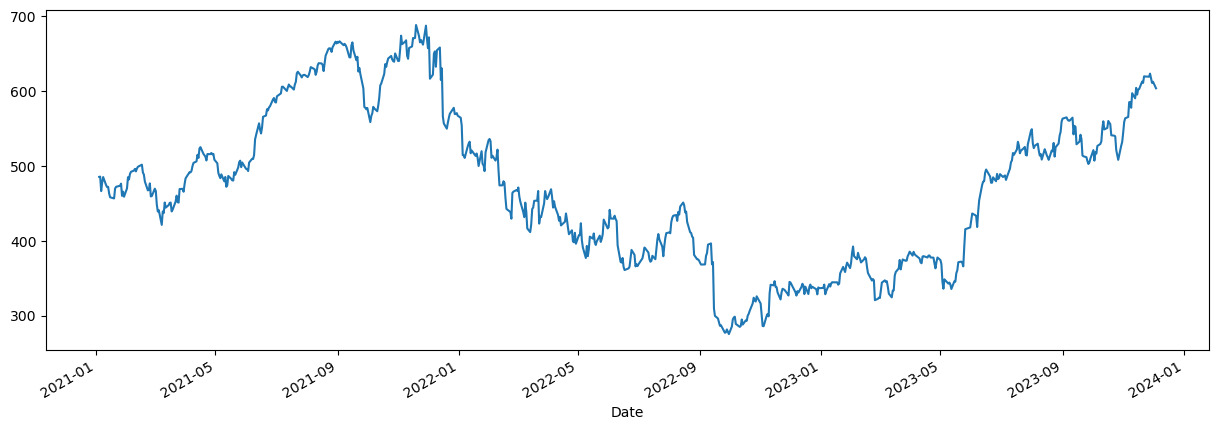

In [184]:
target_col = 'Close'
adobe_stocks[target_col].plot(figsize=(15,5));

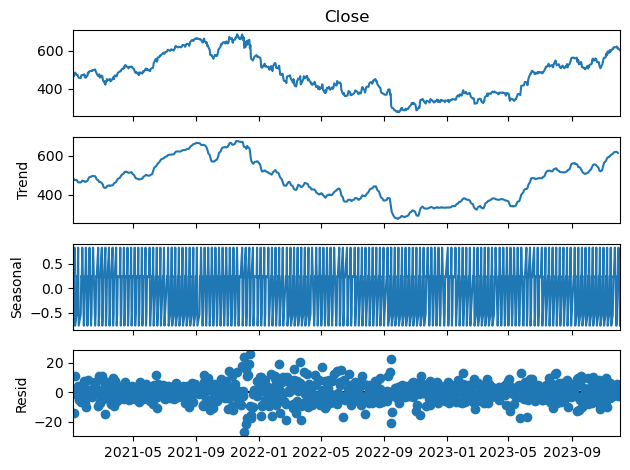

In [185]:
seasonal_decompose(adobe_stocks[target_col], model='additive', period=5).plot();

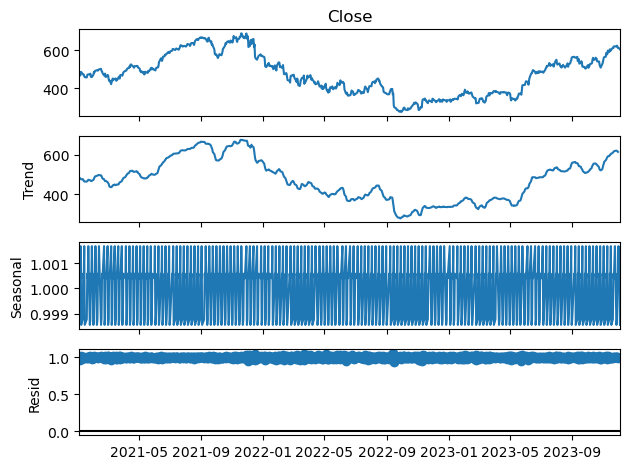

In [186]:
seasonal_decompose(adobe_stocks[target_col], model='multiplicative', period=5).plot();

We can clearly observe that the target variable is not stationary. It has a multiplicative trend for decreasing during the 2022 year till the 7th month, but after that the price for a unit of ADOBE stock, started to rise a little. After October 2022, we can see an increasing additive trend till 2023 October. There are no signs of seasonality in the the series. 

In [187]:
target_col = 'Close'
as_returns = returns_preparation_garch(adobe_stocks, target_col)
as_returns.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,squared_returns
Date,,,,,,,,,
2021-01-05 00:00:00-05:00,485.880005,486.079987,479.200012,485.690002,2010100,0.0,0.0,0.072116,0.005201
2021-01-06 00:00:00-05:00,474.100006,475.869995,466.000000,466.309998,4156600,0.0,0.0,-3.990200,15.921700
2021-01-07 00:00:00-05:00,471.000000,479.640015,468.250000,477.739990,2901200,0.0,0.0,2.451158,6.008173
2021-01-08 00:00:00-05:00,480.000000,485.540009,477.209991,485.100006,2266100,0.0,0.0,1.540590,2.373418
2021-01-11 00:00:00-05:00,481.989990,482.589996,471.299988,474.239990,2382400,0.0,0.0,-2.238717,5.011853
2021-01-12 00:00:00-05:00,474.410004,475.000000,464.000000,471.649994,2964900,0.0,0.0,-0.546136,0.298265
2021-01-13 00:00:00-05:00,472.000000,477.850006,469.299988,472.049988,2105900,0.0,0.0,0.084807,0.007192
2021-01-14 00:00:00-05:00,472.410004,473.549988,462.200012,463.269989,3508300,0.0,0.0,-1.859972,3.459497
2021-01-15 00:00:00-05:00,462.500000,467.880005,457.489990,458.079987,3200400,0.0,0.0,-1.120298,1.255067


In [188]:
train_index = int(0.75 * len(as_returns))
as_returns_train = as_returns[:train_index]
as_returns_test = as_returns[train_index:]

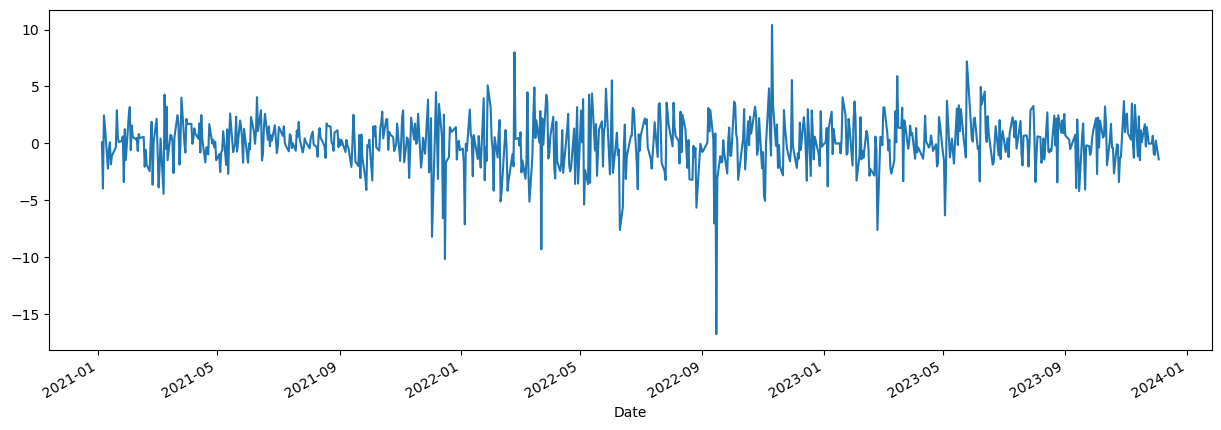

In [189]:
as_returns['returns'].plot(figsize=(15,5));

We can observe that the returns series is stationary as it is more or less constantly reaching the expected mean, which is 0 in this case.

In [190]:
perform_adf_testing(adobe_stocks['Close'].to_frame())
perform_adf_testing(as_returns['returns'].to_frame())

Aadobe_stocks Test Result
---------------
Close:
Aadobe_stocks Statistic: -1.0529351553576105
p-value: 0.7334714991315239
Critical Values:
	1%: -3.439290485895927
	5%: -2.8654856985173414
	10%: -2.568871126669587
Close is non-stationary
---------------
Aadobe_stocks Test Result
---------------
returns:
Aadobe_stocks Statistic: -26.000518788962868
p-value: 0.0
Critical Values:
	1%: -3.439302726125018
	5%: -2.8654910924750547
	10%: -2.5688740002680124
returns is stationary
---------------


The results from the aadobe_stocks-test approve our findings from the visualizations

# ACF PACF Diagnostics

In [191]:
adobe_stocks_full = adobe_stocks.copy()
adobe_stocks_test = adobe_stocks[int((0.85) * len(adobe_stocks)):]
adobe_stocks = adobe_stocks[:int((0.85) * len(adobe_stocks))]

In [192]:
adobe_stocks_full.index = pd.to_datetime(adobe_stocks_full.index, format='%Y-%m-%d')

In [193]:
adobe_stocks_test.index = pd.to_datetime(adobe_stocks_test.index, format='%Y-%m-%d')
adobe_stocks.index = pd.to_datetime(adobe_stocks.index, format='%Y-%m-%d')

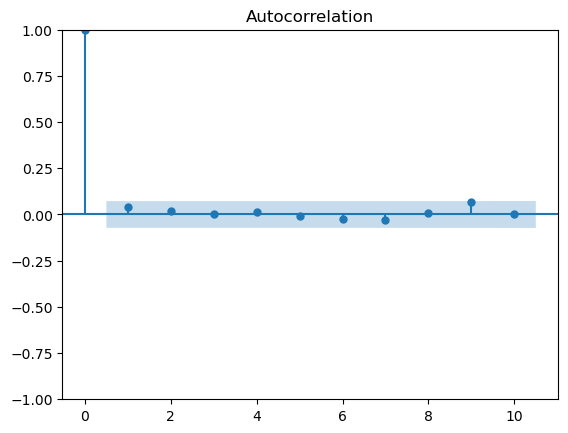

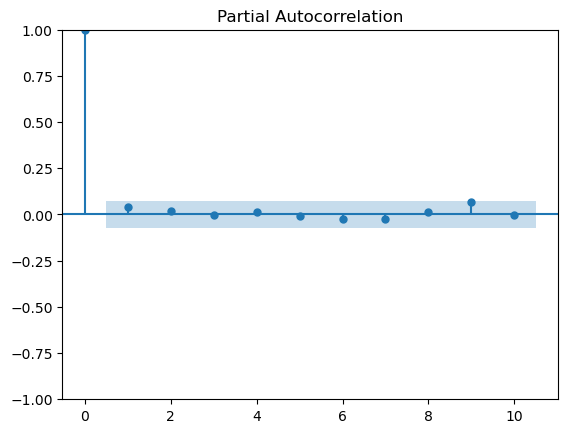

In [194]:
ACF_LAGS = 10
PACF_LAGS = 10

plot_acf(as_returns['returns'], lags=ACF_LAGS);
plot_pacf(as_returns['returns'], lags=PACF_LAGS);

The visualizations for the ACF and PACF of the returns series, indicate that there are no significant lags in the returns series, thus we are most likely dealing with a white noise, having that we should consider an acf/pacf diagnostics of the returns ^ 2 series. As, no signs of an ARMA process is visible, I will skip the ARMA modelling part on the original returns.

In [195]:
# Returns Variations next steps
# If no signifcant lags
def no_lags(adobe_stocks, returns_col = 'returns'):
    adobe_stocks_copy = adobe_stocks.copy()
    adobe_stocks_copy.dropna(inplace=True)
    adobe_stocks_copy['returns_squared'] = adobe_stocks_copy[returns_col]**2
    # adobe_stocks_copy['returns_squared'].plot(figsize=(15,5));
    plot_acf(adobe_stocks_copy['returns_squared'], lags=ACF_LAGS, title="ACF of Squared Returns");
    plot_pacf(adobe_stocks_copy['returns_squared'], lags=PACF_LAGS, title="PACF of Squared Returns");

# If ARMA model is present 
def sig_lags(adobe_stocks, returns_col = 'returns', arma_order = (1,1)):
    #TODO Determine the actions
    pass

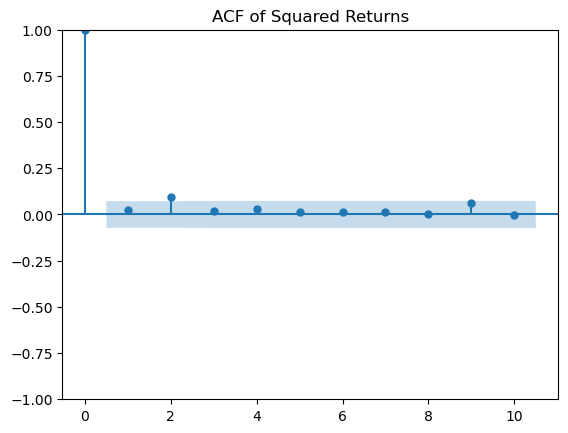

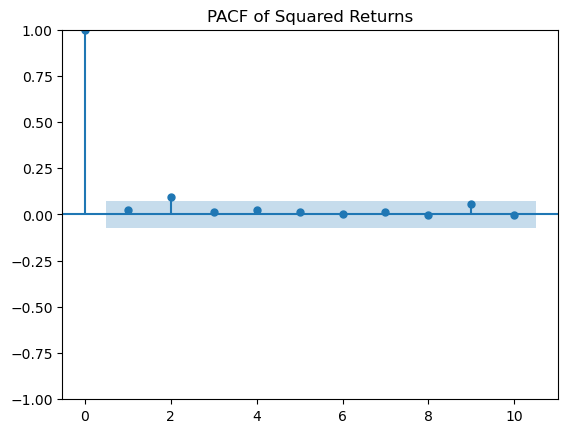

In [196]:
no_lags(as_returns['returns'].to_frame())

When we perform an ACF/PACF diagnostics on the returns squared, we can observe that the second lag is significant both for the ACF and PACF. Let's proceed with fitting a GARCH(1,1) model for the series.

In [197]:
# Best GARCH loop
best_garch_model, GARCH_ORDER = best_garch(as_returns_train, return_col = 'returns', p_max = 4, q_max = 4)

The best garch model is: GARCH((2, 1))
                      Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1217.36
Distribution:                  Normal   AIC:                           2444.72
Method:            Maximum Likelihood   BIC:                           2466.27
                                        No. Observations:                  550
Date:                Mon, Dec 04 2023   Df Residuals:                      549
Time:                        23:21:25   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1357

The for loop approach suggest to use GARCH(2,3), when minimized with AIC,BIC. As there is 

Mean of the residuals: -0.18035327717108493


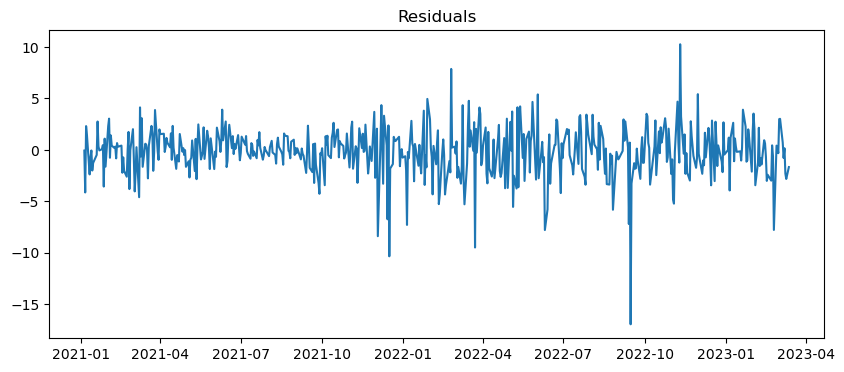

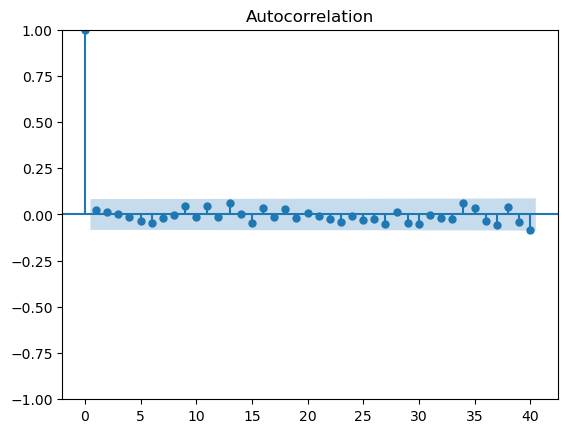

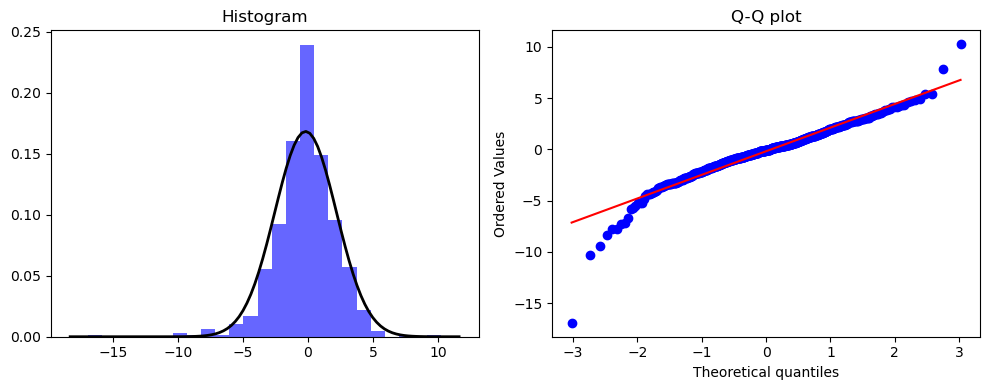

Residuals are independent


,lb_pvalue
1,0.526479
2,0.766238
3,0.911626
4,0.961491
5,0.935833
6,0.882505
7,0.923396
8,0.959396
9,0.921976
10,0.951283


In [198]:
best_garch_residuals = best_garch_model.resid
residuals_diagnostic(best_garch_residuals)
lb_test(best_garch_residuals, 10)

In [199]:
best_garch_model = arch_model(as_returns_train['returns'], p = GARCH_ORDER[0], q = GARCH_ORDER[1]).fit(disp='off')
as_returns_train['best_garch_volatility'] = list(best_garch_model.conditional_volatility)
# manual_garch_model = arch_model(as_returns_train['returns'], p = 1, q = 1).fit(disp='off')
# as_returns_train['manual_garch_volatility'] = list(manual_garch_model.conditional_volatility)

print("MSE of best garch model:", mean_squared_error(as_returns_train['squared_returns'], as_returns_train['best_garch_volatility']))
# print("MSE of manual garch model:", mean_squared_error(as_returns_train['squared_returns'], as_returns_train['manual_garch_volatility']))

MSE of best garch model: 263.1213332948847


In [200]:
# test_forecasts = best_garch_model.forecast(horizon=len(as_returns_test))
garch_model_test = arch_model(as_returns_test['returns'], p = GARCH_ORDER[0], q = GARCH_ORDER[1]).fit(disp='off')
as_returns_test['best_garch_volatility'] = list(garch_model_test.conditional_volatility)

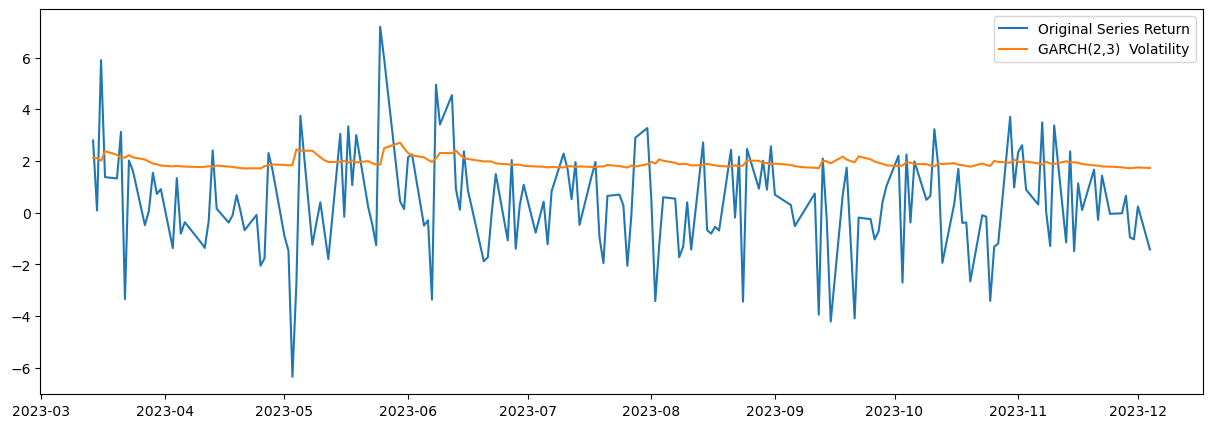

In [201]:
# # # Plotting the forecasted volatility
plt.figure(figsize=(15, 5))
plt.plot(as_returns_test['returns'],label = 'Original Series Return')
plt.plot(as_returns_test['best_garch_volatility'],label = f'GARCH(2,3)  Volatility')
plt.legend();
plt.show();

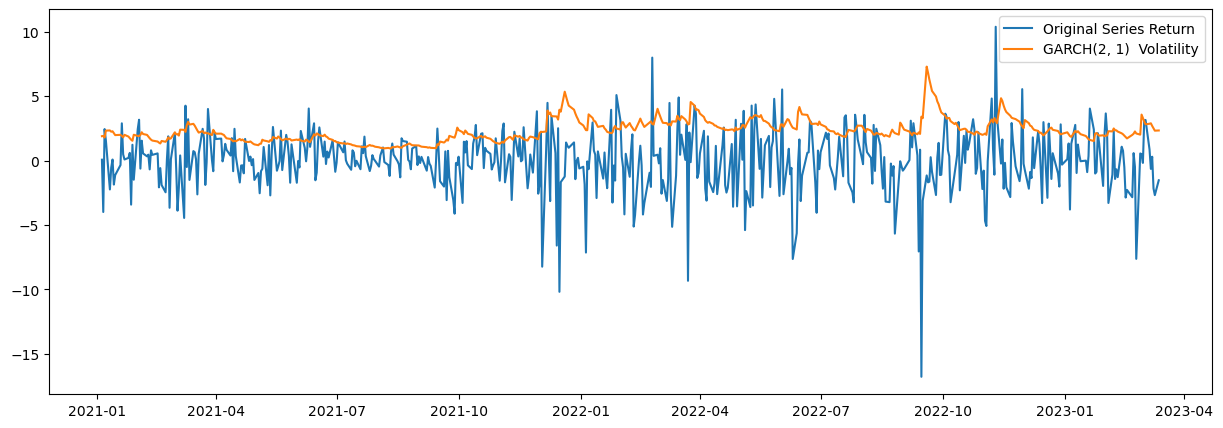

In [202]:
plt.figure(figsize=(15, 5))
plt.plot(as_returns_train['returns'],label = 'Original Series Return')
plt.plot(as_returns_train['best_garch_volatility'],label = f'GARCH{GARCH_ORDER}  Volatility')
plt.legend();
plt.show();

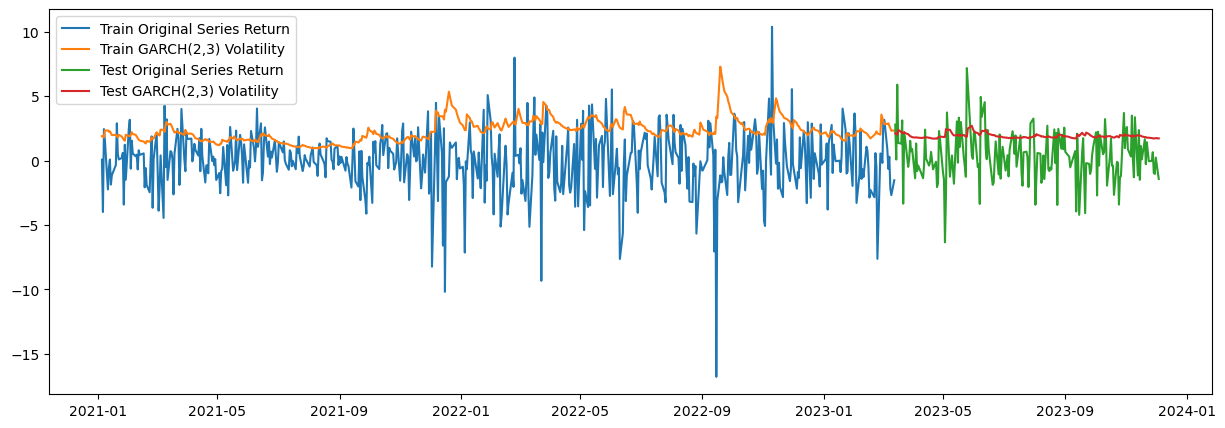

In [203]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(as_returns_train['returns'], label='Train Original Series Return')
plt.plot(as_returns_train['best_garch_volatility'], label='Train GARCH(2,3) Volatility')
plt.plot(as_returns_test['returns'], label='Test Original Series Return')
plt.plot(as_returns_test['best_garch_volatility'], label='Test GARCH(2,3) Volatility')
plt.legend()
plt.show()
